In [1]:
import CaboCha
import re

# 第5章: 係り受け解析
> 夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](/problem/data/neko.txt)）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [2]:
c = CaboCha.Parser()
with open('neko.txt') as rf, open('neko.txt.cabocha', 'w') as wf:
    cabocha = CaboCha.Parser()
    for line in rf:
        wf.write(cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE))

In [3]:
%%bash

head -20 neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.911675
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ


### 40. 係り受け解析結果の読み込み（形態素）
> 形態素を表すクラス`Morph`を実装せよ．このクラスは表層形（`surface`），基本形（`base`），品詞（`pos`），品詞細分類1（`pos1`）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文を`Morph`オブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [4]:
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1

In [5]:
def make_morph(raw_data):
    head_body = raw_data.split('\t')
    head = head_body[0]
    parts = head_body[1].split(',')
    return Morph(head, parts[6], parts[0], parts[1])

with open('neko.txt.cabocha') as f:
    neko = []
    f.seek(0,2)
    size = f.tell()
    f.seek(0)
    while f.tell() < size:
        s = [make_morph(m) for m in iter(f.readline, 'EOS\n') if ',' in m]
        neko.append(s)
for m in neko[2]:
    print(vars(m))

{'surface': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}
{'surface': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'}
{'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surface': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'}
{'surface': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'}
{'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}


### 41. 係り受け解析結果の読み込み（文節・係り受け）
> 40に加えて，文節を表すクラス`Chunk`を実装せよ．このクラスは形態素（`Morph`オブジェクト）のリスト（`morphs`），係り先文節インデックス番号（`dst`），係り元文節インデックス番号のリスト（`srcs`）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文を`Chunk`オブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [6]:
class Chunk:
    def __init__(self, morphs, dst, srcs):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
        
    def __str__(self):
        l = [m.surface for m in self.morphs]
        return '{} -> {}'.format("".join(l), self.dst)

    def trim_text(self):
        l = [m.surface for m in self.morphs if m.pos != '記号']
        return ''.join(l)
    
    def var_noun_text(self, var='X'):
        l = [m for m in self.morphs if m.pos != '記号']
        l = [var if m.pos == '名詞' else m.surface for m in l]
        return ''.join(l)
    
    def is_pos(self, pos):
        return any(m.pos == pos for m in self.morphs)

In [7]:
# iter version
with open('neko.txt.cabocha') as f:
    neko = []
    # In "f.seek(offset, from_what)", from_what=2 means "from last"
    f.seek(0,2)
    size = f.tell()
    f.seek(0)
    while f.tell() < size:
        morphs = []
        chunks = []
        sentence = [s for s in iter(f.readline, 'EOS\n')]
        for line in sentence:
            if line[0] == '*':
                if morphs:
                    chunks.append(Chunk(morphs, dst, []))
                    morphs = []
                data = line.split(' ')
                dst = int(data[2][:-1])
            else:
                morphs.append(make_morph(line))
                
        chunks.append(Chunk(morphs, dst, []))
        # i         dst
        # ...
        # 1 ここで -> 2
        # 2 始めて -> 3
        # ...
        for i, c in enumerate(chunks):
            dst = c.dst
            if dst != -1:
                chunks[dst].srcs.append(i)
        neko.append(chunks)
for i, c in enumerate(neko[7]):
    print(i,c)

0 吾輩は -> 5
1 ここで -> 2
2 始めて -> 3
3 人間という -> 4
4 ものを -> 5
5 見た。 -> -1


In [8]:
# orthodox version
with open('neko.txt.cabocha') as f:
    neko = []
    morphs = []
    chunks = []
    for line in f:
        
        if line[0] == '*':
            if morphs:
                chunks.append(Chunk(morphs, dst, []))
                morphs = []
            data = line.split(' ')
            dst = int(data[2][:-1])
            
        elif line == 'EOS\n':
            if morphs:
                chunks.append(Chunk(morphs, dst, []))
                # i         dst
                # ...
                # 3 我々を -> 4
                # 4 捕えて -> 5
                # ...
                for i, c in enumerate(chunks):
                    dst = c.dst
                    if dst != -1:
                        chunks[dst].srcs.append(i)
                neko.append(chunks)
                morphs = []
                chunks = []
                
        else:
            morphs.append(make_morph(line))
        
for i, c in enumerate(neko[7]):
    print(i,c)

0 この -> 1
1 書生というのは -> 7
2 時々 -> 4
3 我々を -> 4
4 捕えて -> 5
5 煮て -> 6
6 食うという -> 7
7 話である。 -> -1


### 42. 係り元と係り先の文節の表示
> 係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [9]:
l = ['\t'.join((c.trim_text(), chunks[c.dst].trim_text())) 
     for chunks in neko for c in chunks if c.dst != -1]
print(*l[:20], sep='\n')

	猫である
吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た


In [10]:
def extract_pair(sentence, parent_pos='all', child_pos='all'):
    for chunk in sentence:
        dst = chunk.dst
        if dst != -1:
            parent = parent_pos == 'all' or chunk.is_pos(parent_pos)
            child = child_pos == 'all' or sentence[dst].is_pos(child_pos)
            if parent and child:
                yield (chunk.trim_text(), sentence[dst].trim_text())

In [11]:
l = ['\t'.join(pair) for sentence in neko for pair in extract_pair(sentence)]
print(*l[:20], sep='\n')

	猫である
吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
> 名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [12]:
l = ['\t'.join((c.trim_text(), chunks[c.dst].trim_text())) 
     for chunks in neko for c in chunks 
     if c.dst != -1 and c.is_pos('名詞') and chunks[c.dst].is_pos('動詞')]
print(*l[:20], sep='\n')

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている


In [13]:
l = ['\t'.join(pair) for sentence in neko for pair in extract_pair(sentence, '名詞', '動詞')]
print(*l[:20], sep='\n')

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている


### 44. 係り受け木の可視化
> 与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木を[DOT言語](http://ja.wikipedia.org/wiki/DOT%E8%A8%80%E8%AA%9E)に変換し，[Graphviz](http://www.graphviz.org/)を用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，[pydot](https://code.google.com/p/pydot/)を使うとよい．

In [14]:
def chunking(sentence):
    c = CaboCha.Parser()
    tree =  c.parse(sentence)
    sentence = tree.toString(CaboCha.FORMAT_LATTICE)
    morphs = []
    chunks = []
    for line in sentence.split('\n')[:-2]:
        if line[0] == '*':
            if morphs:
                chunks.append(Chunk(morphs, dst, []))
            morphs = []
            data = line.split(' ')
            dst = int(data[2][:-1])
        else:
            morphs.append(make_morph(line))
            
    chunks.append(Chunk(morphs, dst, []))
    for i,c in enumerate(chunks):
        d = c.dst
        if d != -1:
            chunks[d].srcs.append(i)
    return chunks

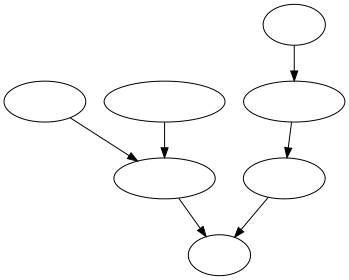

In [15]:
from graphviz import Digraph

dot = Digraph()
sentence = "吾輩は二十世紀の猫だからこのくらいの教育はある。"
chunks = chunking(sentence)
for c in chunks:
    if c.dst != -1:
        dot.edge(c.trim_text() , chunks[c.dst].trim_text())

dot

### 45. 動詞の格パターンの抽出
> 今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい．
動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ．
ただし，出力は以下の仕様を満たすようにせよ．

+ 動詞を含む文節において，最左の動詞の基本形を述語とする
+ 述語に係る助詞を格とする
+ 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

> 「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える．
この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める  で
見る    は を
```

> このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

+ コーパス中で頻出する述語と格パターンの組み合わせ
+ 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）


In [16]:
pattern = []
for chunks in neko:
    found = [c for c in chunks if c.is_pos('動詞')]
    for c in found:
        l = [chunks[i] for i in c.srcs]
        pos = [m.base for c in l for m in c.morphs if m.pos == '助詞']
        left_verb = next(m.base for m in c.morphs if m.pos == '動詞')
        pattern.append('\t'.join((left_verb, ' '.join(pos))))
print(*pattern[:10], sep='\n')

生れる	で
つく	か が
する	
泣く	で
する	て だけ は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て


In [17]:
with open('pattern.txt','w') as f:
    t = '\n'.join(pattern)
    f.write(t)

In [18]:
%%bash
sort pattern.txt | uniq -c | sort -nr | head

 565 云う	と
 442 する	を
 255 する	
 249 思う	と
 199 ある	が
 189 なる	に
 174 する	に
 127 する	と
 108 なる	
  94 ある	


In [19]:
%%bash
grep "^する" pattern.txt | sort | uniq -c | sort -nr | head

 442 する	を
 435 する	
 174 する	に
 127 する	と
 117 する	が
  84 する	て を
  59 する	は
  58 する	を に
  58 する	て
  51 する	が を


In [20]:
%%bash
grep "^見る" pattern.txt | sort | uniq -c | sort -nr | head

 173 見る	て
  94 見る	を
  80 見る	
  21 見る	て て
  20 見る	から
  16 見る	て を
  14 見る	と
  12 見る	で
  11 見る	は て
  11 見る	から て


In [21]:
%%bash
grep "^与える" pattern.txt | sort | uniq -c | sort -nr | head

   3 与える	に を
   1 与える	ば を
   1 与える	は て に を に
   1 与える	は て に を
   1 与える	に は に対して のみ は も
   1 与える	に け を
   1 与える	として を か
   1 与える	で だけ に を
   1 与える	て も を
   1 与える	て は に を


### 46. 動詞の格フレーム情報の抽出
> 45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

+ 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
+ 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

>「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える．
この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める  で      ここで
見る    は を   吾輩は ものを
```

In [22]:
pattern = []
for chunks in neko:
    found = [c for c in chunks if c.is_pos('動詞')]
    for c in found:
        l = [chunks[i] for i in c.srcs]
        pos = [m.base for c in l for m in c.morphs if m.pos == '助詞']
        term = [c.trim_text() for c in l]
        left_verb = next( m.base for m in c.morphs if m.pos == '動詞')
        pattern.append('\t'.join((left_verb, ' '.join(pos), ' '.join(term))))
print(*pattern[:10], sep='\n')

生れる	で	どこで
つく	か が	生れたか とんと 見当が
する		
泣く	で	所で ニャーニャー
する	て だけ は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	時々 我々を
煮る	て	捕えて


### 47. 機能動詞構文のマイニング
> 動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

+ 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
+ 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
+ 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
+ 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

> 例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

```
返事をする      と に は        及ばんさと 手紙に 主人は
```

> このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

+ コーパス中で頻出する述語（サ変接続名詞+を+動詞）
+ コーパス中で頻出する述語と助詞パターン

In [23]:
pattern_sw = []
found = []
for chunks in neko:
    found = [c for c in chunks if c.is_pos('動詞')]
    for c in found:
        l = [chunks[i] for i in c.srcs]
        for k in l:
            ms = k.morphs
            if len(ms)>1 and ms[0].pos1 == 'サ変接続' and ms[1].base == 'を':
                pos = [m.base for c in l for m in c.morphs if m.pos == '助詞'][:-1]
                term = [c.trim_text() for c in l][:-1]
                left_verb = next( m.base for m in c.morphs if m.pos == '動詞')
                verb = ms[0].base + 'を' + left_verb
                pattern_sw.append('\t'.join((verb, ' '.join(pos), ' '.join(term))))
print(*pattern_sw[:10], sep='\n')

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする		よく
昼寝をする	が	彼が
迫害を加える	て	しかも しようものなら 追い廻して
話をする		
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
写生をする		思うなら ちと
昼寝をする	て	出て 善く


In [24]:
with open('sahenwo.txt','w') as f:
    t = '\n'.join(pattern_sw)
    f.write(t)

In [25]:
%%bash
cut -f1 sahenwo.txt | sort | uniq -c | sort -nr | head

  29 返事をする
  21 挨拶をする
  14 話をする
  14 真似をする
  11 喧嘩をする
   8 質問をする
   7 運動をする
   6 話を聞く
   6 昼寝をする
   5 質問をかける


In [26]:
%%bash
cut -f1,2 sahenwo.txt | sort | uniq -c | sort -nr | head

   8 真似をする	
   6 運動をする	
   4 返事をする	と
   4 返事をする	
   4 話を聞く	
   4 挨拶をする	から
   4 喧嘩をする	
   3 話をする	
   3 挨拶をする	と
   3 喧嘩をする	と


### 48. 名詞から根へのパスの抽出
> 文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ．
ただし，構文木上のパスは以下の仕様を満たすものとする．

+ 各文節は（表層形の）形態素列で表現する
+ パスの開始文節から終了文節に至るまで，各文節の表現を"` -> `"で連結する

> 「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
```

In [27]:
path = []
for chunks in neko:
    noun_list = [c for c in chunks if c.is_pos('名詞')]
    for n in noun_list:
        l = [n.trim_text()]
        dst = n.dst
        while True:
            if dst == -1:
                break
            next_c = chunks[dst]
            l.append(next_c.trim_text())
            dst = next_c.dst
        path.append(' -> '.join(l))

print(*path[:10], sep='\n')

一
吾輩は -> 猫である
猫である
名前は -> 無い
どこで -> 生れたか -> つかぬ
見当が -> つかぬ
何でも -> 薄暗い -> 所で -> 泣いて -> 記憶している
所で -> 泣いて -> 記憶している
ニャーニャー -> 泣いて -> 記憶している
いた事だけは -> 記憶している


### 49. 名詞間の係り受けパスの抽出
> 文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号が$i$と$j$（$i < j$）のとき，係り受けパスは以下の仕様を満たすものとする．

+ 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"` -> `"で連結して表現する
+ 文節$i$と$j$に含まれる名詞句はそれぞれ，XとYに置換する

> また，係り受けパスの形状は，以下の2通りが考えられる．

+ 文節$i$から構文木の根に至る経路上に文節$j$が存在する場合: 文節$i$から文節$j$のパスを表示
+ 上記以外で，文節$i$と文節$j$から構文木の根に至る経路上で共通の文節$k$で交わる場合: 文節$i$から文節$k$に至る直前のパスと文節$j$から文節$k$に至る直前までのパス，文節$k$の内容を"` | `"で連結して表示

> 例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
```

In [28]:
import itertools

def makepath(chunks, from_n, to_n=-1):
    dst = from_n
    l = []
    while dst != to_n:
        c = chunks[dst]
        l.append(c.trim_text())
        dst = c.dst
    return l

path = []
for chunks in neko:
    noun_list = [c for c in chunks if c.is_pos('名詞')]
    for a,b in itertools.combinations(noun_list, 2):
        a_path = makepath(chunks, chunks.index(a))
        b_text = b.trim_text()
        if b_text in a_path:
            l = a_path[:a_path.index(b_text)+1]
            l[0] = a.var_noun_text()
            l[-1] = 'Y'
            path.append(' -> '.join(l))
            continue
        b_path = makepath(chunks, chunks.index(b))
        # for back_a, back_b in zip(reversed(a_path), reversed(b_path)):
        while a_path:
            if a_path[-1] != b_path[-1]:
                a_path[0] = a.var_noun_text('X')
                b_path[0] = b.var_noun_text('Y')
                path.append(' | '.join((' -> '.join(a_path),' -> '.join(b_path),former)))
                break
            else:
                former = a_path.pop()
                b_path.pop()

print(*path[:20], sep='\n')

Xは -> Y
Xで -> 生れたか | Yが | つかぬ
Xでも -> 薄暗い -> Y
Xでも -> 薄暗い -> 所で | Y | 泣いて
Xでも -> 薄暗い -> 所で -> 泣いて | Yだけは | 記憶している
Xでも -> 薄暗い -> 所で -> 泣いて -> Y
Xで | Y | 泣いて
Xで -> 泣いて | Yだけは | 記憶している
Xで -> 泣いて -> Y
X -> 泣いて | Yだけは | 記憶している
X -> 泣いて -> Y
Xだけは -> Y
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
Xで -> 聞くと | Yは | 種族であったそうだ
Xで -> 聞くと | Yという -> 人間中で | 種族であったそうだ
